In [412]:
import geopandas as gpd
import numpy as np
import xarray as xr
import os
import pandas as pd
from progressbar import progressbar as pbar
import matplotlib.pyplot as plt
from rlxutils import subplots
import itertools
from earthtext.osm import multilabel

In [23]:
esawc_map = {
'10':	'Tree cover',
'20':	'Shrubland',
'30':	'Grassland',
'40':	'Cropland',
'50':	'Built-up',
'60':	'Bare / sparse vegetation',
'70':	'Snow and ice',
'80':	'Permanent water bodies',
'90':	'Herbaceous wetland',
'95':	'Mangroves',
'100':'Moss and lichen'
}


# read metadata

In [3]:
mfile = '/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet'
esawc_folder = '/opt/data/california-worldcover-chips/esaworldcover-2020'

In [282]:
m = gpd.read_parquet(mfile)
m.head()

,onehot_count,onehot_area,onehot_length,string_labels,col,row,geometry,esawc_proportions
chip_id,,,,,,,,
193c3415fc237,"[24, 24, 1344, 388, 472, 21, 453, 2, 8, 0, 0, ...","[58033.967200952815, 58033.967200952815, 23937...","[4913.205774298301, 4913.205774298301, 74943.4...","[amenity=*, amenity=parking, building=*, build...",78080,96000,"POLYGON ((-118.47200 33.97867, -118.47200 34.0...","{'10': 0.0118408203125, '100': 0.0, '20': 0.0,..."
1639b12583426,"[148, 148, 4171, 1245, 1891, 52, 938, 13, 32, ...","[160073.78667008967, 160073.78667008967, 80191...","[20966.344659970102, 20966.344659970102, 24881...","[amenity=*, amenity=parking, building=*, build...",78080,95744,"POLYGON ((-118.47200 34.00000, -118.47200 34.0...","{'10': 0.0895843505859375, '100': 0.0, '20': 0..."
253904d963d6a,"[65, 65, 200, 104, 76, 0, 18, 2, 0, 0, 0, 0, 0...","[101980.95118259436, 101980.95118259436, 71246...","[10597.989172272657, 10597.989172272657, 16664...","[amenity=*, amenity=parking, building=*, build...",77824,95744,"POLYGON ((-118.49333 34.00000, -118.49333 34.0...","{'10': 0.0130157470703125, '100': 0.0, '20': 0..."
00530dca88d4a,"[9, 9, 4897, 688, 4026, 0, 172, 10, 1, 0, 0, 0...","[17637.908172952746, 17637.908172952746, 10930...","[1925.4953839123748, 1925.4953839123748, 32065...","[amenity=*, amenity=parking, building=*, build...",77824,95488,"POLYGON ((-118.49333 34.02133, -118.49333 34.0...","{'10': 0.3690948486328125, '100': 0.0, '20': 0..."
0e554bbdbe661,"[80, 80, 4358, 1262, 2386, 59, 597, 27, 27, 0,...","[131950.60085068244, 131950.60085068244, 98472...","[13536.03447682216, 13536.03447682216, 283601....","[amenity=*, amenity=parking, building=*, build...",78080,95488,"POLYGON ((-118.47200 34.02133, -118.47200 34.0...","{'10': 0.1365509033203125, '100': 0.0, '20': 0..."


# compute esawc proportions

In [12]:
esawc_proportions = {}
for chip_id in pbar(m.index):
    fname = f'{esawc_folder}/{chip_id}.tif'
    if os.path.isfile(fname):
        with xr.open_dataarray(fname) as z:
            x = z.data.copy()
        p = {int(k):v/np.product(x.shape) for k,v in zip(*np.unique(x, return_counts=True))}
        esawc_proportions[chip_id] = p

esawc_proportions = pd.DataFrame(esawc_proportions).fillna(0).T

100% (83609 of 83609) |##################| Elapsed Time: 0:09:55 Time:  0:09:550448


In [17]:
esawc_proportions.columns = [str(c) for c in esawc_proportions.columns]

In [18]:
esawc_proportions.head()

,10,30,50,60,80,40,20,90,100,70,95
193c3415fc237,0.011841,0.005463,0.219101,0.095901,0.667694,0.000000,0.0,0.0,0.0,0.0,0.0
1639b12583426,0.089584,0.030670,0.813522,0.040649,0.025528,0.000046,0.0,0.0,0.0,0.0,0.0
253904d963d6a,0.013016,0.002396,0.216782,0.118393,0.649414,0.000000,0.0,0.0,0.0,0.0,0.0
00530dca88d4a,0.369095,0.022888,0.581589,0.024063,0.002365,0.000000,0.0,0.0,0.0,0.0,0.0
0e554bbdbe661,0.136551,0.004654,0.855179,0.003616,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [19]:
z = [[c, dict(p)] for c, p in esawc_proportions.iterrows()]
z = pd.DataFrame(z, columns = ['chip_id', 'esawc_proportions']).set_index('chip_id')
z.head()

,esawc_proportions
chip_id,
193c3415fc237,"{'10': 0.0118408203125, '30': 0.00546264648437..."
1639b12583426,"{'10': 0.0895843505859375, '30': 0.03067016601..."
253904d963d6a,"{'10': 0.0130157470703125, '30': 0.00239562988..."
00530dca88d4a,"{'10': 0.3690948486328125, '30': 0.02288818359..."
0e554bbdbe661,"{'10': 0.1365509033203125, '30': 0.00465393066..."


In [20]:
z.shape, m.shape

((83609, 1), (83609, 8))

In [21]:
mz = m.join(z)
mz.head()

,onehot_count,onehot_area,onehot_length,string_labels,col,row,geometry,split,esawc_proportions
chip_id,,,,,,,,,
193c3415fc237,"[24, 24, 1344, 388, 472, 21, 453, 2, 8, 0, 0, ...","[58033.967200952815, 58033.967200952815, 23937...","[4913.205774298301, 4913.205774298301, 74943.4...","[amenity=*, amenity=parking, building=*, build...",78080,96000,"POLYGON ((-118.47200 33.97867, -118.47200 34.0...",train,"{'10': 0.0118408203125, '30': 0.00546264648437..."
1639b12583426,"[148, 148, 4171, 1245, 1891, 52, 938, 13, 32, ...","[160073.78667008967, 160073.78667008967, 80191...","[20966.344659970102, 20966.344659970102, 24881...","[amenity=*, amenity=parking, building=*, build...",78080,95744,"POLYGON ((-118.47200 34.00000, -118.47200 34.0...",train,"{'10': 0.0895843505859375, '30': 0.03067016601..."
253904d963d6a,"[65, 65, 200, 104, 76, 0, 18, 2, 0, 0, 0, 0, 0...","[101980.95118259436, 101980.95118259436, 71246...","[10597.989172272657, 10597.989172272657, 16664...","[amenity=*, amenity=parking, building=*, build...",77824,95744,"POLYGON ((-118.49333 34.00000, -118.49333 34.0...",train,"{'10': 0.0130157470703125, '30': 0.00239562988..."
00530dca88d4a,"[9, 9, 4897, 688, 4026, 0, 172, 10, 1, 0, 0, 0...","[17637.908172952746, 17637.908172952746, 10930...","[1925.4953839123748, 1925.4953839123748, 32065...","[amenity=*, amenity=parking, building=*, build...",77824,95488,"POLYGON ((-118.49333 34.02133, -118.49333 34.0...",train,"{'10': 0.3690948486328125, '30': 0.02288818359..."
0e554bbdbe661,"[80, 80, 4358, 1262, 2386, 59, 597, 27, 27, 0,...","[131950.60085068244, 131950.60085068244, 98472...","[13536.03447682216, 13536.03447682216, 283601....","[amenity=*, amenity=parking, building=*, build...",78080,95488,"POLYGON ((-118.47200 34.02133, -118.47200 34.0...",train,"{'10': 0.1365509033203125, '30': 0.00465393066..."


In [22]:
mz.to_parquet(mfile)

In [286]:
mz = m

In [508]:
# get a list of all tags
all_tags = {}
for _,mi in pbar(mz.iterrows(), max_value=len(mz)):
    for k,v in zip(np.argwhere(mi.onehot_count!=0)[:,0], mi.string_labels):
        all_tags[k] = v

100% (86119 of 86119) |##################| Elapsed Time: 0:00:06 Time:  0:00:060000


In [429]:
[(k,v) for k,v in all_tags.items() if v=='power=*']

[(64, 'power=*')]

# compute correlations between osm tags and easwc class proportions

In [430]:
all_esawc_classes = list(esawc_map.keys())
all_esawc_classes

['10', '20', '30', '40', '50', '60', '70', '80', '90', '95', '100']

In [416]:
tag = 'building=*'
esawc_class = '50'

def get_tag_eswc_stats(tag, esawc_class, use_pbar=False):
    r = []
    if not use_pbar:
        pbar = lambda x,max_value: x
    for chip_id,mi in pbar(mz.iterrows(), max_value=len(mz)):
        idx = multilabel.kvmerged.keyvals_codes[tag]
        
        tag_count = mi.onehot_count[idx]
        tag_area = mi.onehot_area[idx]
        tag_length = mi.onehot_length[idx]

        if mi.esawc_proportions is None:
            continue
        
        esawc_props = mi.esawc_proportions[esawc_class]
        r.append([chip_id, tag_count, tag_area, tag_length, esawc_props])
    r = pd.DataFrame(r, columns=['chip_id', 'tag_count', 'tag_area', 'tag_length', 'esawc_props'])
    return r

In [313]:
def getcorr(tag, esawc_class):
    r = get_tag_eswc_stats(tag, esawc_class)
    ccount   = np.corrcoef(r.esawc_props, r.tag_count)[0,1]
    carea   = np.corrcoef(r.esawc_props, r.tag_area)[0,1]
    clength = np.corrcoef(r.esawc_props, r.tag_length)[0,1]
    return ccount, carea, clength

In [521]:
# get a list of all tags
all_tags = {}
for _,mi in pbar(mz.iterrows(), max_value=len(mz)):
    for k,v in zip(np.argwhere(mi.onehot_count!=0)[:,0], mi.string_labels):
        all_tags[k] = v


100% (86119 of 86119) |##################| Elapsed Time: 0:00:06 Time:  0:00:060000


In [522]:
#all_tags = general_tags
alltc = list(itertools.product(list(all_tags.values()), all_esawc_classes))
tr = [getcorr(*tc) for tc in pbar(alltc)]

 30% (330 of 1089) |######               | Elapsed Time: 0:27:45 ETA:   1:03:51/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100% (1089 of 1089) |####################| Elapsed Time: 1:31:59 Time:  1:31:594530


In [523]:
zcount = np.zeros((len(all_tags), len(all_esawc_classes)))
zarea = np.zeros((len(all_tags), len(all_esawc_classes)))
zlength = np.zeros((len(all_tags), len(all_esawc_classes)))
tc = np.r_[alltc]
for i,k in enumerate(sorted(list(all_tags.keys()))):
    for j,esawc_class in enumerate(all_esawc_classes):
        tag = all_tags[k]
        idx = np.argwhere((tc == [tag, esawc_class]).sum(axis=1)==2)
        if len(idx)==0:
            count,area,length = 0,0,0
        else:
            count, area, length = tr[idx[0,0]]
        
        zcount[i,j] = count
        zarea[i,j] = area
        zlength[i,j] = length
zcount.shape

(99, 11)

Text(0.5, 0, 'OSM tags')

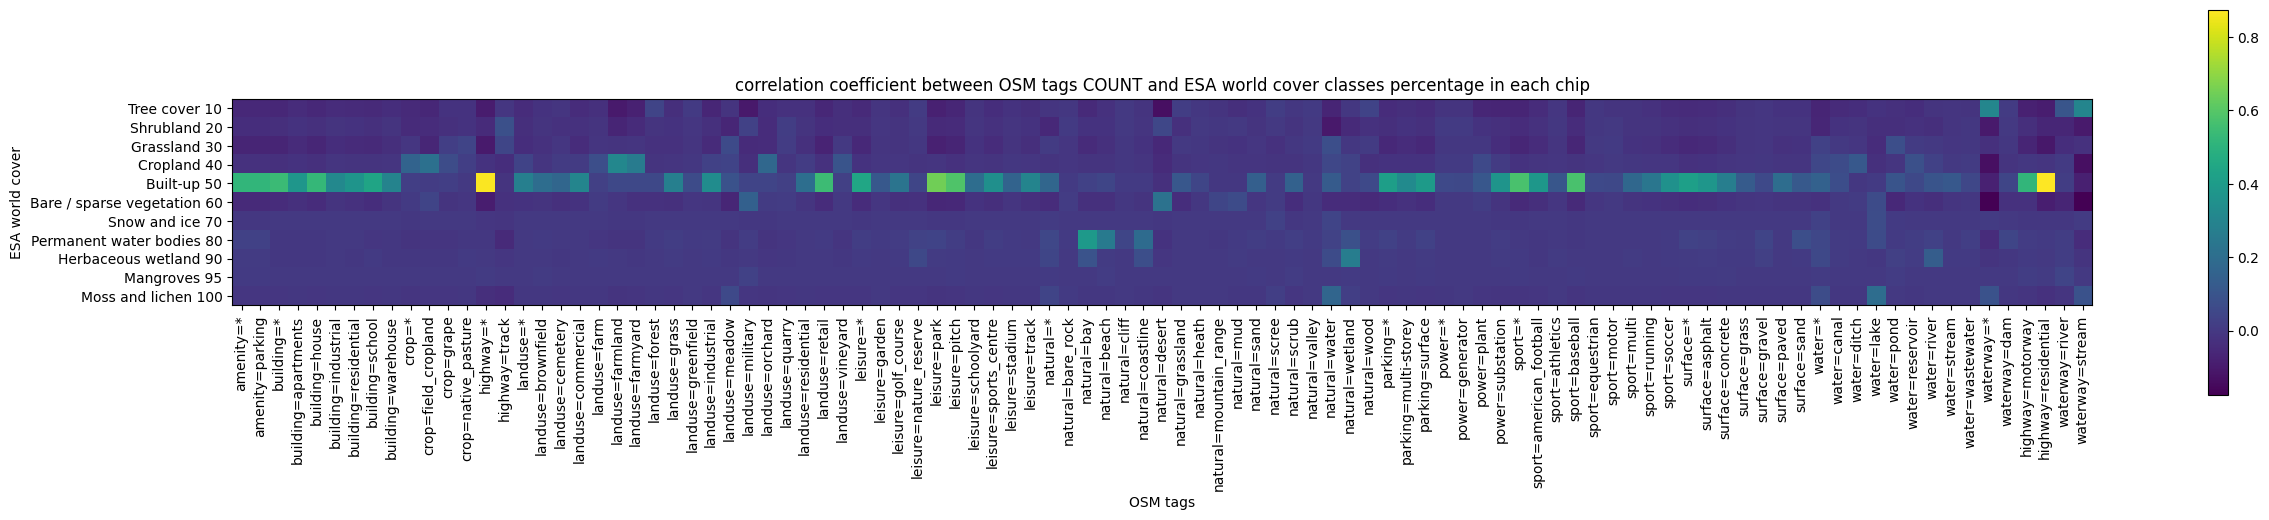

In [531]:
plt.figure(figsize=(30,5))
plt.imshow(zcount.T)
plt.xticks(range(len(all_tags)), [all_tags[i] for i in sorted(list(all_tags.keys()))], rotation='vertical');
plt.yticks(range(len(all_esawc_classes)), [f"{esawc_map[c]} {c}" for c in all_esawc_classes])
plt.colorbar()
plt.title("correlation coefficient between OSM tags COUNT and ESA world cover classes percentage in each chip")
plt.ylabel("ESA world cover")
plt.xlabel("OSM tags")

Text(0.5, 0, 'OSM tags')

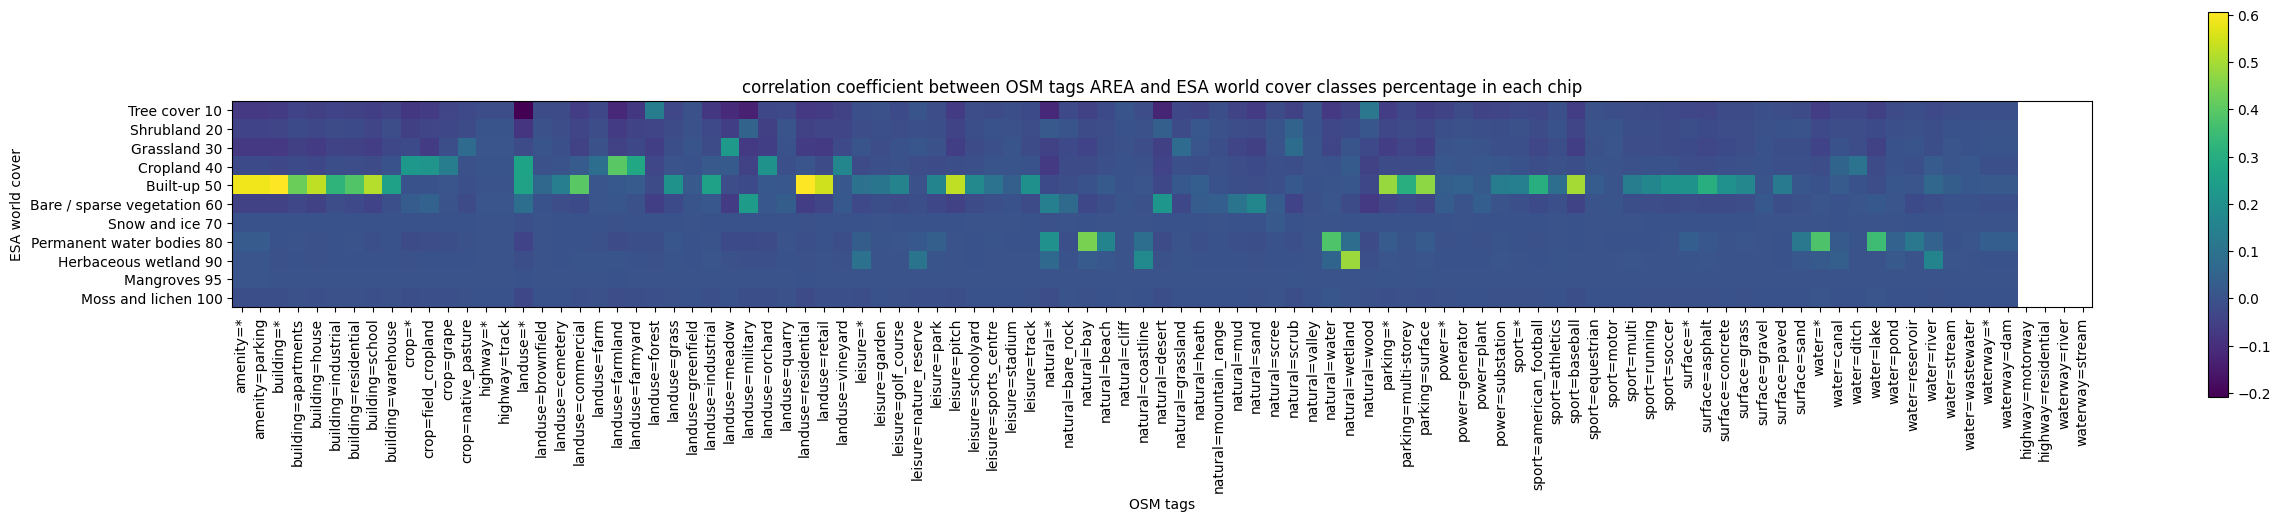

In [533]:
plt.figure(figsize=(30,5))
plt.imshow(zarea.T)
plt.xticks(range(len(all_tags)), [all_tags[i] for i in sorted(list(all_tags.keys()))], rotation='vertical');
plt.yticks(range(len(all_esawc_classes)), [f"{esawc_map[c]} {c}" for c in all_esawc_classes])
plt.colorbar()
plt.title("correlation coefficient between OSM tags AREA and ESA world cover classes percentage in each chip")
plt.ylabel("ESA world cover")
plt.xlabel("OSM tags")

Text(0.5, 0, 'OSM tags')

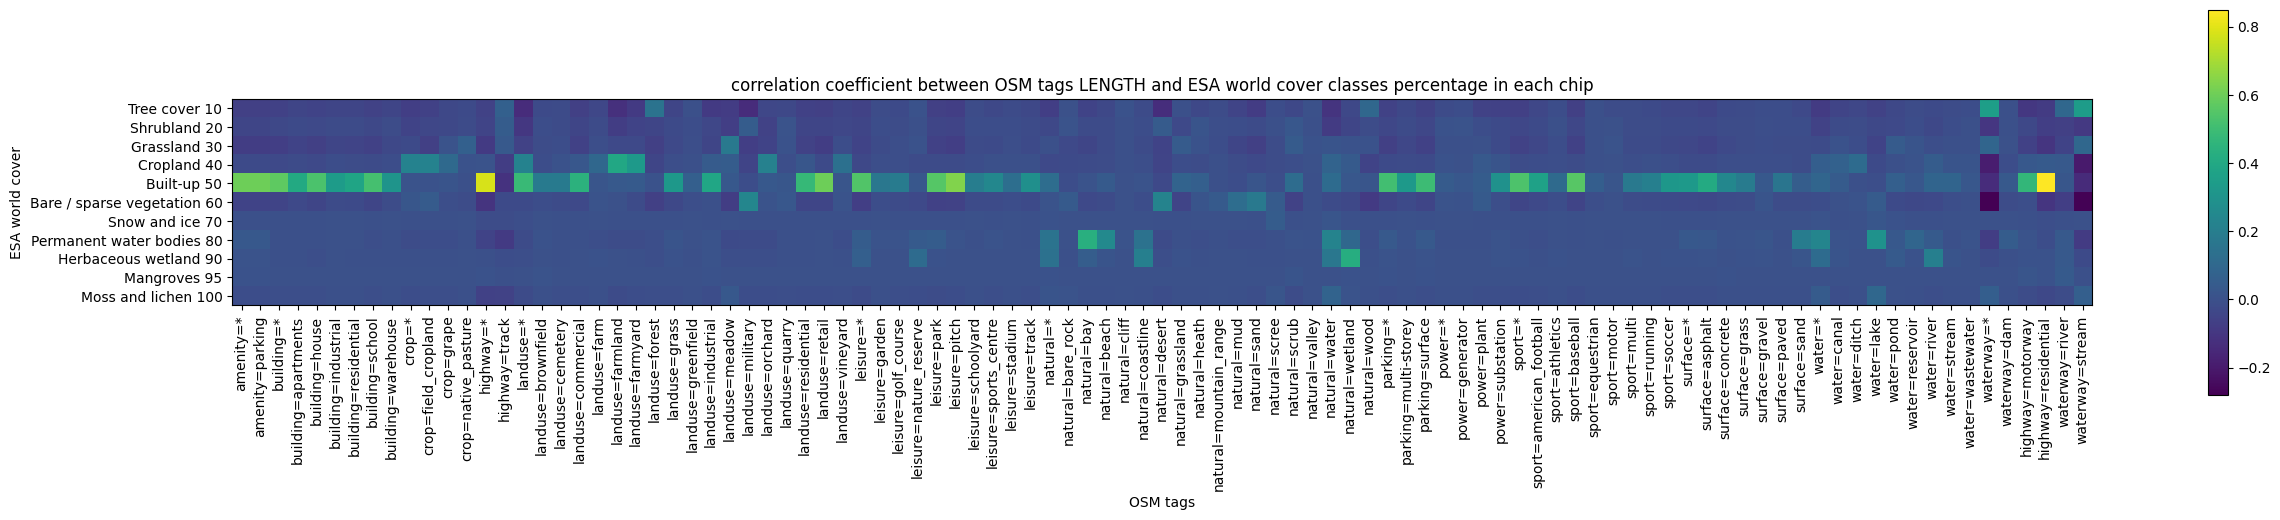

In [534]:
plt.figure(figsize=(30,5))
plt.imshow(zlength.T)
plt.xticks(range(len(all_tags)), [all_tags[i] for i in sorted(list(all_tags.keys()))], rotation='vertical');
plt.yticks(range(len(all_esawc_classes)), [f"{esawc_map[c]} {c}" for c in all_esawc_classes])
plt.colorbar()
plt.title("correlation coefficient between OSM tags LENGTH and ESA world cover classes percentage in each chip")
plt.ylabel("ESA world cover")
plt.xlabel("OSM tags")